Setup
====

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import nltk
import numpy as np
nltk.download('punkt')
%matplotlib inline


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
DATA_NAME = "Isoflavones" #"Bacillus" "ERIS"
idx = {"ERIS":0, "Isoflavones": 1, "Bacillus": 2}


data_paths = [f'drive/MyDrive/Data/refsa-sample-data/{x}/use_as_train_{x}.csv' for x in ["ERIS", "Isoflavones", "Bacillus"]]
validation_paths =  [f'drive/MyDrive/Data/refsa-sample-data/{x}/use_as_validation_{x}.csv' for x in ["ERIS", "Isoflavones", "Bacillus"]]
preprocessed_dir = 'drive/MyDrive/Data/refsa-sample-data/cleaned/'

In [4]:
#loading preprocessed data to make each section indepenent
def load_preprocessed(which):
  datasets = ["cleaned", "bow", "glove", "tfidf", "no_lemma"]
  if which not in datasets:
    print("Expected one of the values: ", datasets)
    return
  df_train = pd.read_csv(preprocessed_dir + which + f"_train_{DATA_NAME}.csv", index_col=0)
  df_test = pd.read_csv(preprocessed_dir + which + f"_test_{DATA_NAME}.csv", index_col=0)
  X_train = df_train.drop("Indicator", axis=1)
  y_train = df_train["Indicator"]

  X_test = df_test.drop("Indicator", axis=1)
  y_test = df_test["Indicator"]
  return X_train, X_test, y_train, y_test

Initial data exploration
====



In [5]:
df = pd.read_csv(data_paths[idx[DATA_NAME]], index_col=0)
df_test = pd.read_csv(validation_paths[idx[DATA_NAME]], index_col=0)
print("Class -1")
print("Train data:", len(df[df['Indicator']==-1]), "out of", len(df))
print("Test data:", len(df_test[df_test['Indicator']==-1]),"out of" , len(df_test))

print("Class 1")
print("Train data:",len(df[df['Indicator']==1]), "out of", len(df))
print("Test data:",len(df_test[df_test['Indicator']==1]),"out of" , len(df_test))

Class -1
Train data: 5207 out of 5494
Test data: 1277 out of 1373
Class 1
Train data: 287 out of 5494
Test data: 96 out of 1373


In [6]:
df.head()

,Refid,Author,Title,Abstract,Journal,Keywords,Pages,Volume,Year,Indicator
3117,3290,NCT01698164,Multi-centre Clinical Trial on Hormone Replace...,Recruiting No Results Available Drug: estradio...,NaN,Menopausal Syndrome|Cardiovascular Disease|Ost...,NaN,NaN,2008.0,-1
3119,3291,NCT00244933,Gemcitabine Hydrochloride and Genistein in Tre...,Completed No Results Available Dietary Supplem...,NaN,Breast Cancer,NaN,NaN,2004.0,1
3121,3292,NCT01276704,Prevention Strategy for Pre-Menopausal Women a...,Recruiting No Results Available Drug: Placebo|...,NaN,Breast Cancer,NaN,NaN,2010.0,-1
3123,3293,NCT00925639,Effects of the Concentrated Extract of Soy on ...,Not yet recruiting No Results Available Drug: ...,NaN,Menopause,NaN,NaN,2009.0,1
3125,3294,NCT00275704,Flaxseed for the Treatment of Hot Flashes,Completed No Results Available Drug: Flaxseed ...,NaN,Hot Flashes,NaN,NaN,2005.0,-1


In [7]:
#check for null values
df.isnull().sum()

Refid           0
Author         17
Title           0
Abstract        0
Journal      4289
Keywords      536
Pages         319
Volume        209
Year            4
Indicator       0
dtype: int64

In [8]:
X = df[["Title", "Abstract"]].copy()
y_train = df["Indicator"]

X_test = df_test[["Title", "Abstract"]]
y_test = df_test["Indicator"]

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

#preprocess train data
vectorizerAb = CountVectorizer()
vectorizerTit = CountVectorizer()

preprocessedAbstract = vectorizerAb.fit_transform(X["Abstract"].values)
abstracts = pd.DataFrame(data=preprocessedAbstract.toarray(), index=X.index, columns = vectorizerAb.get_feature_names())

preprocessedTitle = vectorizerTit.fit_transform(X["Title"].values)
titles = pd.DataFrame(data=preprocessedTitle.toarray(), index=X.index, columns = vectorizerTit.get_feature_names())

x_train = pd.concat([abstracts, titles], axis=1)

preprocessedAbstract = vectorizerAb.transform(X_test["Abstract"].values)
abstracts = pd.DataFrame(data=preprocessedAbstract.toarray(), index=X_test.index, columns = vectorizerAb.get_feature_names())

preprocessedTitle = vectorizerTit.transform(X_test["Title"].values)
titles = pd.DataFrame(data=preprocessedTitle.toarray(), index=X_test.index, columns = vectorizerTit.get_feature_names())

x_test= pd.concat([abstracts, titles], axis=1)
print(x_test.shape, x_train.shape)

(1373, 37652) (5494, 37652)


In [10]:
# Both train and test datasets are very small so it would be a good idea to first
# check if they come from the same data distribution using Adversial Validation
# crashes for Isoflavones because of ram usage
# from scipy import sparse
# from sklearn.metrics import roc_auc_score
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import StratifiedKFold

# def adversial_validation(train_df, test_df, n_splits=5):
#   train_df["__dist"]=np.zeros((train_df.shape[0],))
#   test_df["__dist"]=np.ones((test_df.shape[0],))

#   merged = pd.concat([train_df, test_df], axis=0)
#   features = merged.drop("__dist", axis=1)
#   dists = merged["__dist"]

#   auc_log = []
#   auc_rf = []
#   kfold = StratifiedKFold(n_splits=n_splits, shuffle=True)

#   for train_idx, test_idx in kfold.split(features, dists):
#     x_train, y_train = features.take(train_idx), dists.take(train_idx)
#     x_test, y_test = features.take(test_idx), dists.take(test_idx)

#     #train sgd
#     log = LogisticRegression()
#     log.fit(x_train, y_train)
#     test_prob = log.predict_proba(x_test)[:,1]
#     auc_log.append(roc_auc_score(y_test, test_prob))

#     #train random forests
#     rf = RandomForestClassifier(n_estimators=100, n_jobs = 1)
#     rf.fit(x_train, y_train)
#     test_prob = rf.predict_proba(x_test)[:,1]
#     auc_rf.append(roc_auc_score(y_test, test_prob))

#   print(f'RandomForest: {np.mean(auc_rf)}')
#   print(f'Logistic Regression: {np.mean(auc_log)}')

# adversial_validation(x_train.copy(), x_test.copy()) 

AUC score abround 50 % siginifies that test data is drawn from the same distribution as train data. That's good news - one worry less

Cleaning the data
===


In [11]:
df = pd.read_csv(data_paths[idx[DATA_NAME]], index_col=0)
df_test = pd.read_csv(validation_paths[idx[DATA_NAME]], index_col=0)

X = df.drop("Indicator", axis=1)
y_train = df["Indicator"]

X_test = df_test.drop("Indicator", axis=1)
y_test = df_test["Indicator"]
print(X.shape, y_train.shape, X_test.shape, y_test.shape)
X.head()

(5494, 9) (5494,) (1373, 9) (1373,)


,Refid,Author,Title,Abstract,Journal,Keywords,Pages,Volume,Year
3117,3290,NCT01698164,Multi-centre Clinical Trial on Hormone Replace...,Recruiting No Results Available Drug: estradio...,NaN,Menopausal Syndrome|Cardiovascular Disease|Ost...,NaN,NaN,2008.0
3119,3291,NCT00244933,Gemcitabine Hydrochloride and Genistein in Tre...,Completed No Results Available Dietary Supplem...,NaN,Breast Cancer,NaN,NaN,2004.0
3121,3292,NCT01276704,Prevention Strategy for Pre-Menopausal Women a...,Recruiting No Results Available Drug: Placebo|...,NaN,Breast Cancer,NaN,NaN,2010.0
3123,3293,NCT00925639,Effects of the Concentrated Extract of Soy on ...,Not yet recruiting No Results Available Drug: ...,NaN,Menopause,NaN,NaN,2009.0
3125,3294,NCT00275704,Flaxseed for the Treatment of Hot Flashes,Completed No Results Available Drug: Flaxseed ...,NaN,Hot Flashes,NaN,NaN,2005.0


In [12]:
for abs in df["Abstract"][:1]:
    print(abs + "\n")

Recruiting No Results Available Drug: estradiol plus MPA|Drug: Ximingting Tablet|Drug: estradiol plus progesterone Female Adult Phase 4 1200 Interventional Allocation: Randomized|Endpoint Classification: Safety/Efficacy Study|Intervention Model: Parallel Assignment|Primary Purpose: Treatment|Masking: Open Label Change from Baseline in risk factors of cardiovascular disease at 12 months and 24 months|Change from Baseline in risk factors of breast cancer at 12 months and 24 months|Change from Baseline in BMD at 12 months and 24 months|Change from Baseline in risk factors of senile dementia every three months|Change from Baseline in the quality of life every three months



Things to consider when cleaning the data:
- abreviations
- numeric values and citation numbers
- hyphenated words like *mosquito-borne*

There is probably no need to remove contractions due to scientific nature of the data. 


In [13]:
#tokenize and lowercase
from nltk.tokenize import word_tokenize

def tokenize_and_lower(s):
    return [x.lower() for x in word_tokenize(s)]


X["tokenized_abstract"] = X["Abstract"].apply(tokenize_and_lower)
X_test["tokenized_abstract"] = X_test["Abstract"].apply(tokenize_and_lower)

X.head()

,Refid,Author,Title,Abstract,Journal,Keywords,Pages,Volume,Year,tokenized_abstract
3117,3290,NCT01698164,Multi-centre Clinical Trial on Hormone Replace...,Recruiting No Results Available Drug: estradio...,NaN,Menopausal Syndrome|Cardiovascular Disease|Ost...,NaN,NaN,2008.0,"[recruiting, no, results, available, drug, :, ..."
3119,3291,NCT00244933,Gemcitabine Hydrochloride and Genistein in Tre...,Completed No Results Available Dietary Supplem...,NaN,Breast Cancer,NaN,NaN,2004.0,"[completed, no, results, available, dietary, s..."
3121,3292,NCT01276704,Prevention Strategy for Pre-Menopausal Women a...,Recruiting No Results Available Drug: Placebo|...,NaN,Breast Cancer,NaN,NaN,2010.0,"[recruiting, no, results, available, drug, :, ..."
3123,3293,NCT00925639,Effects of the Concentrated Extract of Soy on ...,Not yet recruiting No Results Available Drug: ...,NaN,Menopause,NaN,NaN,2009.0,"[not, yet, recruiting, no, results, available,..."
3125,3294,NCT00275704,Flaxseed for the Treatment of Hot Flashes,Completed No Results Available Drug: Flaxseed ...,NaN,Hot Flashes,NaN,NaN,2005.0,"[completed, no, results, available, drug, :, f..."


In [14]:
#remove punctuation and stopwords
import string
from nltk.corpus import stopwords
nltk.download('stopwords')

chars_for_removal = set(list(string.punctuation) + stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
def filter_words(string_list):
    return [word for word in string_list if word not in chars_for_removal]

X["filtered_abstract"] = X["tokenized_abstract"].apply(filter_words)
X_test["filtered_abstract"] = X_test["tokenized_abstract"].apply(filter_words)

X.head()

,Refid,Author,Title,Abstract,Journal,Keywords,Pages,Volume,Year,tokenized_abstract,filtered_abstract
3117,3290,NCT01698164,Multi-centre Clinical Trial on Hormone Replace...,Recruiting No Results Available Drug: estradio...,NaN,Menopausal Syndrome|Cardiovascular Disease|Ost...,NaN,NaN,2008.0,"[recruiting, no, results, available, drug, :, ...","[recruiting, results, available, drug, estradi..."
3119,3291,NCT00244933,Gemcitabine Hydrochloride and Genistein in Tre...,Completed No Results Available Dietary Supplem...,NaN,Breast Cancer,NaN,NaN,2004.0,"[completed, no, results, available, dietary, s...","[completed, results, available, dietary, suppl..."
3121,3292,NCT01276704,Prevention Strategy for Pre-Menopausal Women a...,Recruiting No Results Available Drug: Placebo|...,NaN,Breast Cancer,NaN,NaN,2010.0,"[recruiting, no, results, available, drug, :, ...","[recruiting, results, available, drug, placebo..."
3123,3293,NCT00925639,Effects of the Concentrated Extract of Soy on ...,Not yet recruiting No Results Available Drug: ...,NaN,Menopause,NaN,NaN,2009.0,"[not, yet, recruiting, no, results, available,...","[yet, recruiting, results, available, drug, is..."
3125,3294,NCT00275704,Flaxseed for the Treatment of Hot Flashes,Completed No Results Available Drug: Flaxseed ...,NaN,Hot Flashes,NaN,NaN,2005.0,"[completed, no, results, available, drug, :, f...","[completed, results, available, drug, flaxseed..."


In [16]:
#save unfiltered data
def list_to_string (str_list):
  return " ".join(str_list)

X["abs_str"] = X["filtered_abstract"].apply(list_to_string)
X_test["abs_str"] = X_test["filtered_abstract"].apply(list_to_string)

df_train = pd.concat([X["abs_str"], y_train], axis=1)
df_test = pd.concat([X_test["abs_str"], y_test], axis=1)

df_train.to_csv(preprocessed_dir + f"no_lemma_train_{DATA_NAME}.csv")
df_test.to_csv(preprocessed_dir + f"no_lemma_test_{DATA_NAME}.csv")

In [17]:
#adding pos tags for lemmatization with wordnet
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

X["pos_abstract"] = X["filtered_abstract"].apply(nltk.tag.pos_tag)
X_test["pos_abstract"] = X_test["filtered_abstract"].apply(nltk.tag.pos_tag)

def map_to_wordnet_pos(tuple_list):
    return [(word, get_wnet_tag(tag)) for (word, tag) in tuple_list]
 
def get_wnet_tag(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    if tag.startswith('V'):
        return wordnet.VERB
    if tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
X_test["wntag_abstract"] = X_test["pos_abstract"].apply(map_to_wordnet_pos)  
X["wntag_abstract"] = X["pos_abstract"].apply(map_to_wordnet_pos)   


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [18]:
#lemmatize with wordnet
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

def lemmatize(tuple_list):
    return [lemmatizer.lemmatize(word, tag) for (word, tag) in tuple_list]

X["lem_abstract"] = X["wntag_abstract"].apply(lemmatize)

X_test["lem_abstract"] = X_test["wntag_abstract"].apply(lemmatize)

cleaned_text = pd.DataFrame(data=X["lem_abstract"], index = X.index)
cleaned_text = cleaned_text.rename(columns={"lem_abstract": "abstract"})

cleaned_text_test = pd.DataFrame(data=X_test["lem_abstract"], index = X_test.index)
cleaned_text_test = cleaned_text_test.rename(columns={"lem_abstract": "abstract"})


In [19]:
# connect lists back into strings

cleaned_text["abs_str"] = cleaned_text["abstract"].apply(list_to_string)

cleaned_text_test["abs_str"] = cleaned_text_test["abstract"].apply(list_to_string)

cleaned_text = cleaned_text.drop(labels = ["abstract"], axis=1)
cleaned_text_test = cleaned_text_test.drop(labels = ["abstract"], axis=1)

print(cleaned_text.head())

                                                abs_str
3117  recruit result available drug estradiol plus m...
3119  complete result available dietary supplement g...
3121  recruit result available drug placebo|drug sec...
3123  yet recruit result available drug isoflavone|d...
3125  complete result available drug flaxseed female...


In [20]:
clean_train = pd.concat([cleaned_text, y_train], axis=1)
clean_train.to_csv(preprocessed_dir + f"cleaned_train_{DATA_NAME}.csv")
clean_test =pd.concat([cleaned_text_test, y_test], axis=1)
clean_test.to_csv(preprocessed_dir +f"cleaned_test_{DATA_NAME}.csv")
print(clean_train.shape, clean_test.shape)

(5494, 2) (1373, 2)


Exploratory Data Analysis
===

In [21]:
X_train, X_test, y_train, y_test = load_preprocessed("cleaned")
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape) #sanity check
X_train.head()

(5494, 1) (1373, 1) (5494,) (1373,)


,abs_str
3117,recruit result available drug estradiol plus m...
3119,complete result available dietary supplement g...
3121,recruit result available drug placebo|drug sec...
3123,yet recruit result available drug isoflavone|d...
3125,complete result available drug flaxseed female...


In [22]:
X_rel = X_train[y_train==1]
X_irrel = X_train[y_train==-1]

abs_words_rel = []
for abs_word in X_rel["abs_str"]:
  abs_words_rel += abs_word.split(" ")

abs_words_irrel = []
for abs_word in X_irrel["abs_str"]:
  abs_words_irrel += abs_word.split(" ")


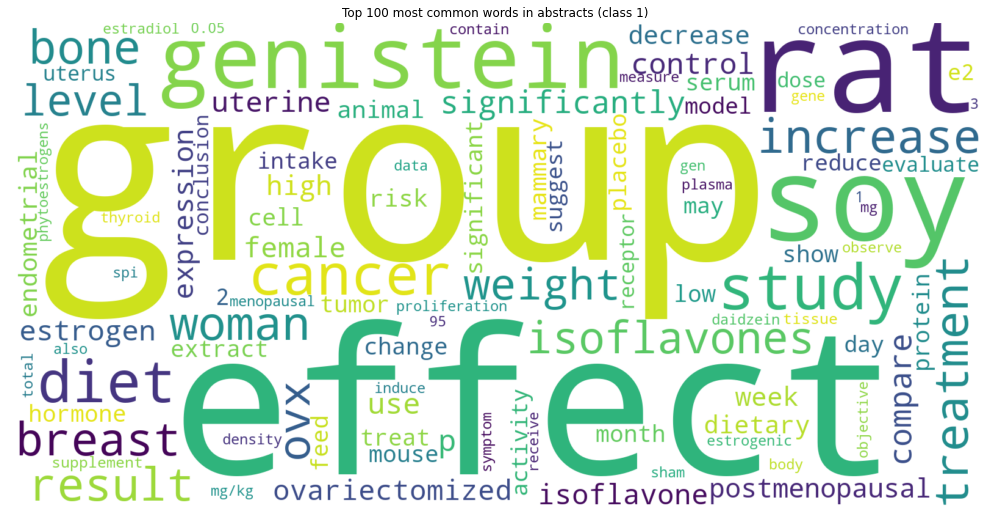

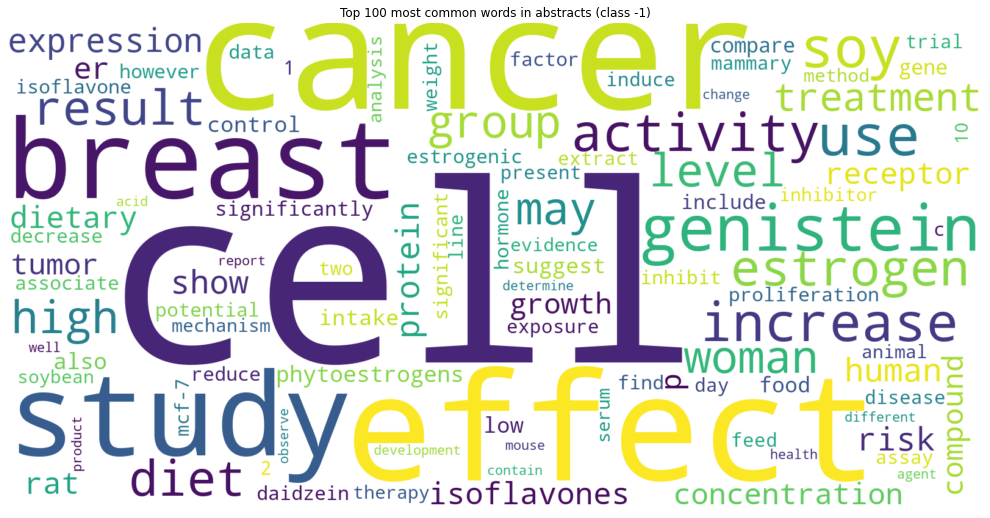

In [23]:
from nltk.probability import FreqDist
from wordcloud import WordCloud
def to_dict(tuple_list):
  result = dict()
  for key, value in tuple_list:
    result[key]=value
  return result


most_rel = to_dict(FreqDist(abs_words_rel).most_common(100))
cloud_a = WordCloud(width=1600, height= 800, background_color='white').fit_words(most_rel)
fig = plt.figure(figsize=(20,7), facecolor='white')
plt.imshow(cloud_a, interpolation='bilinear')
plt.axis('off')
plt.title('Top 100 most common words in abstracts (class 1)')
plt.tight_layout(pad=0)
plt.show()
print("\n\n")
most_irrel = to_dict(FreqDist(abs_words_irrel).most_common(100))
cloud_a = WordCloud(width=1600, height= 800, background_color='white').fit_words(most_irrel)
fig = plt.figure(figsize=(20,7), facecolor='white')
plt.imshow(cloud_a, interpolation='bilinear')
plt.axis('off')
plt.title('Top 100 most common words in abstracts (class -1)')
plt.tight_layout(pad=0)
plt.show()

A first glance look at most popular words in both classes does not seem to indicate much difference between them - they both talk about oysters and fish, research and its results

In [24]:
#dimensionality reduction for visualisation purposes
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=50, n_iter=10)
reduced_train = svd.fit_transform(x_train)

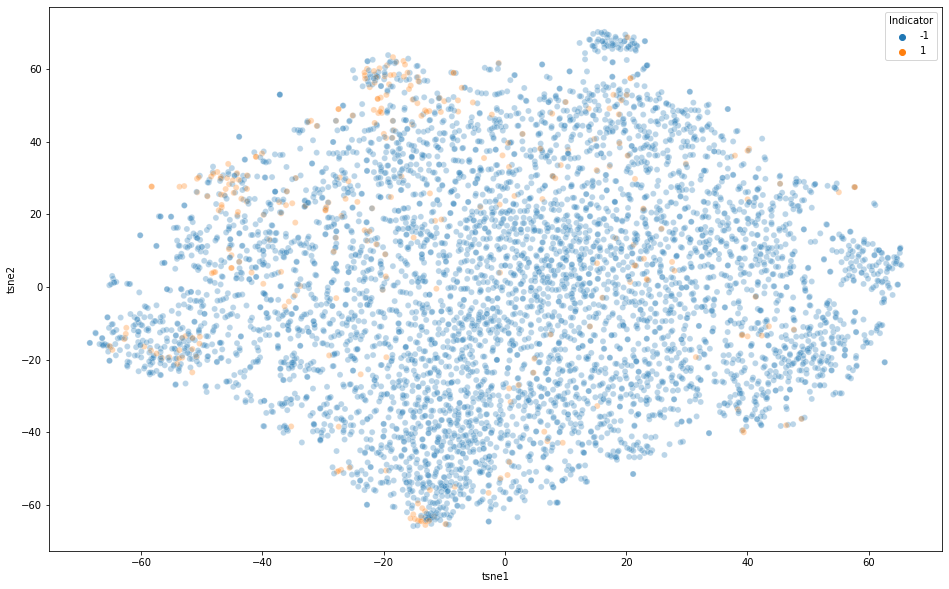

In [25]:
from sklearn.manifold import TSNE
X_embedded = pd.DataFrame(TSNE(n_components=2).fit_transform(reduced_train), index = x_train.index, columns=["tsne1", "tsne2"])

plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne1", y="tsne2", hue = y_train, data = X_embedded, legend="full", alpha=0.3, palette = sns.color_palette(n_colors=2) )


Both of the classes seem very mixed with bow encoding so it will most likely be necessary to explore different embedding options

Classification
===


In [26]:
X_train, X_test, y_train, y_test = load_preprocessed("cleaned")
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5494, 1) (1373, 1) (5494,) (1373,)


In [27]:
#baseline classifier - always return majority class
class BaselineClassifier:
    def __init__(self):
        self.majority_class = np.NaN
        
    def fit(self, x, y):
        self.majority_class = y.value_counts()[:1].index.to_list()[0]
        return
    def predict(self, x):
        return pd.Series(np.ones((x.shape[0],)) * self.majority_class, index = x.index)
    
    def score(self, x, y):
        p = self.predict(x)
        comp = y==p
        return len(comp[comp==True])/len(comp)
        
        
baseline = BaselineClassifier()
baseline.fit(X_test,y_train)
score = baseline.score(X_test, y_test)
print(f'Baseline classifier\'s accuracy (always returns majority class): {score}')

Baseline classifier's accuracy (always returns majority class): 0.9300801165331392


**Baseline classifier** achieves expected accuracy -  84,84% which corresponds to how many of training examples are of majority class. 

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

#preprocess train data
vectorizerAb = CountVectorizer()
vectorizerTit = CountVectorizer()

preprocessedAbstract = vectorizerAb.fit_transform(X_train["abs_str"].values)
abstracts = pd.DataFrame(data=preprocessedAbstract.toarray(), index=cleaned_text.index, columns = vectorizerAb.get_feature_names())

x_train = abstracts
print(x_train.shape)
print(x_train.head())

(5494, 27837)
      00  000  000000  00001  ...  香豆素类  高脂组  高脂组与高脂组相比  高脂组及si
3117   0    0       0      0  ...     0    0          0       0
3119   0    0       0      0  ...     0    0          0       0
3121   0    0       0      0  ...     0    0          0       0
3123   0    0       0      0  ...     0    0          0       0
3125   0    0       0      0  ...     0    0          0       0

[5 rows x 27837 columns]


In [29]:
#preprocess test data
abstracts_test = vectorizerAb.transform(cleaned_text_test["abs_str"].values)

x_test = pd.DataFrame(data=abstracts_test.toarray(), index = cleaned_text_test.index, columns = vectorizerAb.get_feature_names())

print(x_test.shape)
x_test.head()

(1373, 27837)


,00,000,000000,00001,00004,00005,00007,00008,0001,0002,0003,0004,0005,0006,0007,0008,0009,000g,001,0012,0013,0015,0016,0017,002,0021,0029,003,0031,0033,0038,004,0040,0045,0047,00498,005,0052,006,007,...,目的观察全身垂直振动,稳定表达are荧光报告基因后,细胞培养基中分别加入50,结果,结果与去卵巢组比较,结果在mcf7,结果表明,结肠癌细胞,结论全身垂直振动和跑台运动均能刺激去卵巢骨质疏松大鼠子宫gsk,结论植物雌激素白藜芦醇,结论补充摄入大豆异黄酮可降低dmba诱导高脂饮食幼龄大鼠乳腺肿瘤的恶性程度,羟基,羟基苯乙酸为原料,而振动组,而金雀异黄酮无,而金雀异黄酮组无显著变化,能与机体的雌激素受体结合,脂素类及其他结构类型的化合物,药理作用和安全性等最新研究进展,蛋白表达的,表达情况,记录体质量和饲料摄入量,该文综述了植物雌激素的植物来源,诱导效应具有剂量依赖性和组织特异性,诱导的高脂饮食幼龄sd雌性大鼠乳腺癌发病率的影响,跑台组,跑台组和振动组大鼠子宫p,跑台运动和金雀异黄酮对去卵巢骨质疏松大鼠子宫重量指数和组织形态学以及糖原合成激酶3beta,转录调控蛋白keapl可能参与了诱导反应机制,酮能够在人类宫颈癌细胞hela,采用mtt法考察了3和5a,金雀异黄酮组和雌激素组,金雀异黄酮组大鼠子宫重量指数均无显著变化,长期暴露或过量使用植物雌激素对雄性生殖系统和胎儿的造血功能有一定的影响,雌激素组,雌激素组大鼠子宫重量指数显著增加,香豆素类,高脂组,高脂组与高脂组相比,高脂组及si
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
# save vectorized test and train data
test_bow = pd.concat([x_test, y_test], axis=1)
train_bow = pd.concat([x_train, y_train], axis=1)
print(test_bow.shape, train_bow.shape)
test_bow.to_csv(preprocessed_dir + f"bow_test_{DATA_NAME}.csv")
train_bow.to_csv(preprocessed_dir + f"bow_train_{DATA_NAME}.csv")

(1373, 27838) (5494, 27838)


In [31]:
from sklearn.linear_model import LogisticRegression
scores = {}
y = y_train
logistic = LogisticRegression()
logistic.fit(x_train, y)
test_score_logistic = logistic.score(x_test, y_test)
train_score_logistic = logistic.score(x_train, y_train)
print(f'Accuracy for Logistic Regression Classifier with CountVectorization\n test: {test_score_logistic}\t\t train: {train_score_logistic}')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy for Logistic Regression Classifier with CountVectorization
 test: 0.9402767662053897		 train: 0.9998179832544594


In [32]:
from sklearn.svm import LinearSVC
scores = {}
y = y_train
linearSVC = LinearSVC()
linearSVC.fit(x_train, y)
test_score_linearSVC = linearSVC.score(x_test, y_test)
train_score_linearSVC = linearSVC.score(x_train, y_train)
print(f'Accuracy for Linear SVC with CountVectorization\n test: {test_score_linearSVC}\t train: {train_score_linearSVC}')

Accuracy for Linear SVC with CountVectorization
 test: 0.932993445010925	 train: 1.0


Improving classification
====



Utilities
---

In [33]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, recall_score
def calculate_metrics (X_test, y_test, model, verbose=False, confusion = False):
  y_pred = model.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  re = recall_score(y_test, y_pred)
  if confusion:
    cm = confusion_matrix(y_test, y_pred)

    plt.title('Confusion Matrix')
    sns.set(font_scale=1.0) #for label size
    sns.heatmap(cm, annot = True, fmt = 'd', xticklabels = ['-1', '1'], yticklabels = ['-1', '1'], annot_kws={"size": 14}, cmap = 'Blues')

    plt.xlabel('Truth')
    plt.ylabel('Prediction')
    plt.show()
  if verbose:
    print(f'Accuracy: {acc}\tF1 score: {f1}\tRecall: {re}')
  return (acc, f1, re)

Bag of Words model
---

In [34]:
x_test, x_train, y_test, y_train = load_preprocessed("bow")
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape) #sanity check

(1373, 27837) (5494, 27837) (1373,) (5494,)


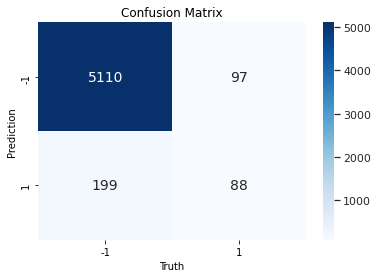

Accuracy: 0.9461230433199854	F1 score: 0.3728813559322034	Recall: 0.30662020905923343


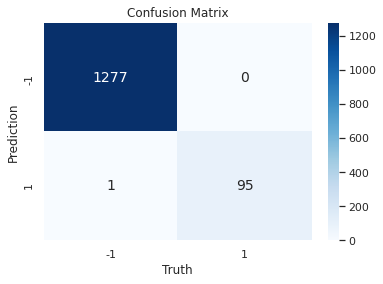

Accuracy: 0.9992716678805535	F1 score: 0.9947643979057591	Recall: 0.9895833333333334


In [35]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression()
logistic.fit(x_train, y_train)
#print("Scores for LogisticRegression with BOW model - test data")
log_bow = calculate_metrics(x_test, y_test, logistic, True, True)
#print("Scores for LogisticRegression with BOW model - train data")
log_bow = calculate_metrics(x_train, y_train, logistic, True, True)

TF-IDF vectorization
----


In [36]:
X_train, X_test, y_train, y_test = load_preprocessed("cleaned")
X_train.head()

,abs_str
3117,recruit result available drug estradiol plus m...
3119,complete result available dietary supplement g...
3121,recruit result available drug placebo|drug sec...
3123,yet recruit result available drug isoflavone|d...
3125,complete result available drug flaxseed female...


In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
document_list = X_train["abs_str"].tolist()
test_docs = X_test["abs_str"].tolist()


tfidf = TfidfVectorizer()
x_train_tfidf = pd.DataFrame(tfidf.fit_transform(document_list).toarray(), 
                             index = X_train.index, columns = tfidf.get_feature_names())
x_test_tfidf =  pd.DataFrame(tfidf.transform(test_docs).toarray(), 
                             index = X_test.index, columns = tfidf.get_feature_names())
print(x_train_tfidf.shape, x_test_tfidf.shape)

(5494, 27837) (1373, 27837)


In [38]:
df_train = pd.concat([x_train_tfidf, y_train], axis=1)
df_train.to_csv(preprocessed_dir + f"tfidf_train_{DATA_NAME}.csv")

df_test = pd.concat([x_test_tfidf, y_test], axis=1)
df_test.to_csv(preprocessed_dir + f"tfidf_test_{DATA_NAME}.csv")

Scores for LogisticRegression with tfidf model


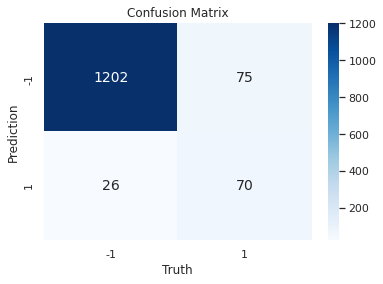

Accuracy: 0.9264384559359068	F1 score: 0.5809128630705394	Recall: 0.7291666666666666


In [39]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression(class_weight='balanced', max_iter=10000) #increasing max iteration number due to convergence issues
logistic.fit(x_train_tfidf, y_train)
print("Scores for LogisticRegression with tfidf model")
log_tfidf = calculate_metrics(x_test_tfidf, y_test, logistic, True, True)

Word embeddings
----

In [40]:
X_train, X_test, y_train, y_test = load_preprocessed("no_lemma")
X_train.head()

,abs_str
3117,recruiting results available drug estradiol pl...
3119,completed results available dietary supplement...
3121,recruiting results available drug placebo|drug...
3123,yet recruiting results available drug isoflavo...
3125,completed results available drug flaxseed fema...


In [41]:
import io

def load_glove():
  glove_dir = "drive/MyDrive/Data/embeddings/glove.6B/glove.6B.100d.txt"
  embeddings_idx = {}
  with io.open(glove_dir) as glove_f:
    for line in glove_f:
      values = line.split()
      word = values[0]
      vector = np.asarray(values[1:],dtype='float32')
      embeddings_idx[word]=vector
  return embeddings_idx

glove_dict = load_glove()


In [42]:
def avg_glove(word_list):
  vectors =[]
  for word in word_list:
    if word in glove_dict.keys():
      vectors.append(glove_dict[word])
  return np.array(vectors).mean(axis=0)

In [43]:
embed_list_train = [avg_glove(row["abs_str"]) for idx, row in X_train.iterrows()]
embeddings_train = pd.DataFrame(embed_list_train, index = X_train.index)

embed_list_test = [avg_glove(row["abs_str"]) for idx, row in X_test.iterrows()]
embeddings_test = pd.DataFrame(embed_list_test, index = X_test.index)

In [44]:
glove_train = pd.concat([embeddings_train, y_train], axis=1)
glove_test = pd.concat([embeddings_test, y_test], axis=1)

glove_test.to_csv(preprocessed_dir + f"glove_test_{DATA_NAME}.csv")
glove_train.to_csv(preprocessed_dir + f"glove_train_{DATA_NAME}.csv")


Comparison of different classifiers
----


To compare - 3 vectorization methods and 4 classifiers (RandomForest, LinearSVC, LogisticRegression, kNN)

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve
from sklearn.metrics import average_precision_score, roc_auc_score

In [46]:
vec_method = ["bow", "tfidf", "glove"]
vec_to_full = {"bow": "Bag of Words", "tfidf": "TF-IDF", "glove": "Averaged GloVe"}
class_types = ["log", "rf","knn"]

#prepare scores dict
auc_scores = {}
avg_pr_scores = {}
for m in vec_method:
  auc_scores[m]={}
  avg_pr_scores[m]={}
  for c in class_types:
    auc_scores[m][c]=-1
    avg_pr_scores[m][c]=-1


Comparison of classification methods for Bag of Words representation of documents


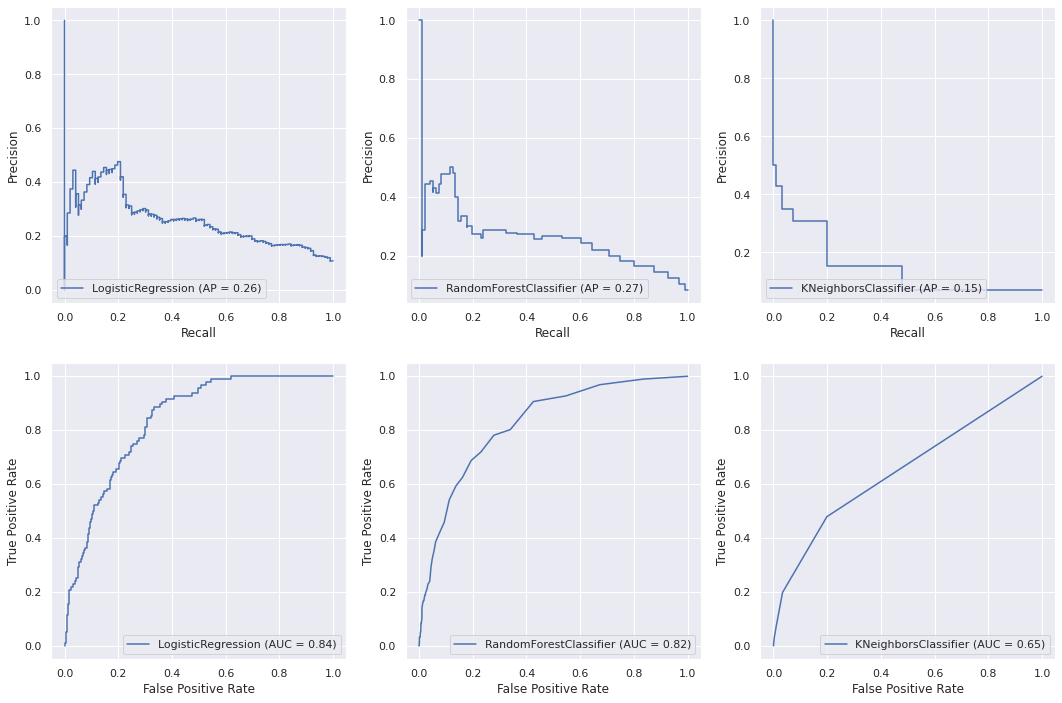




Comparison of classification methods for TF-IDF representation of documents


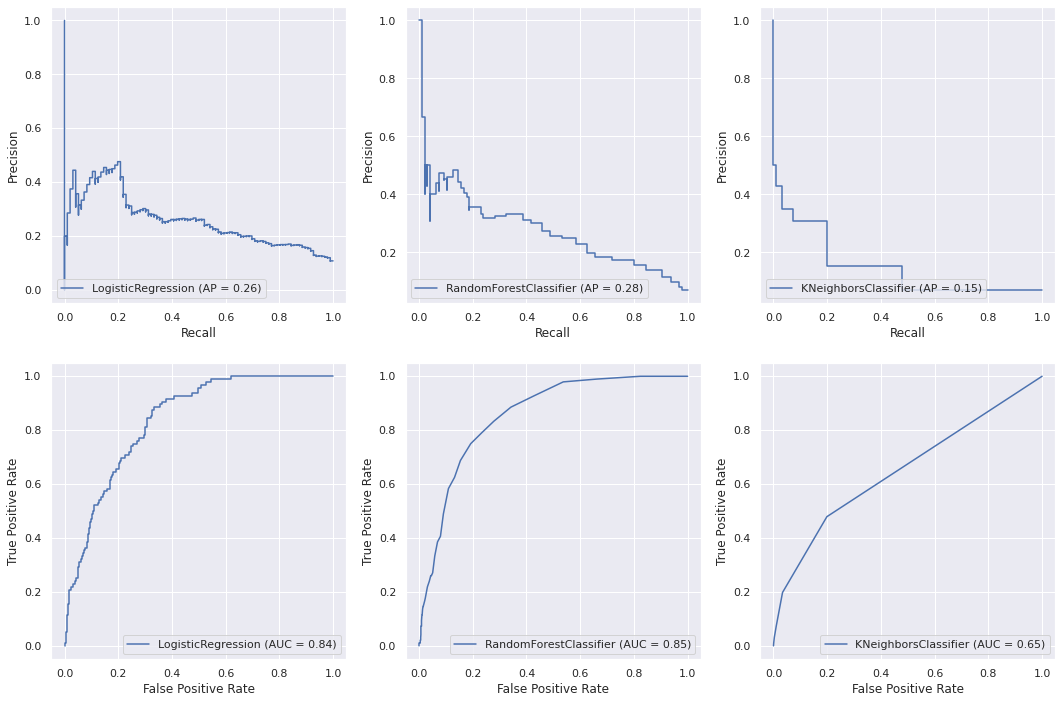




Comparison of classification methods for Averaged GloVe representation of documents


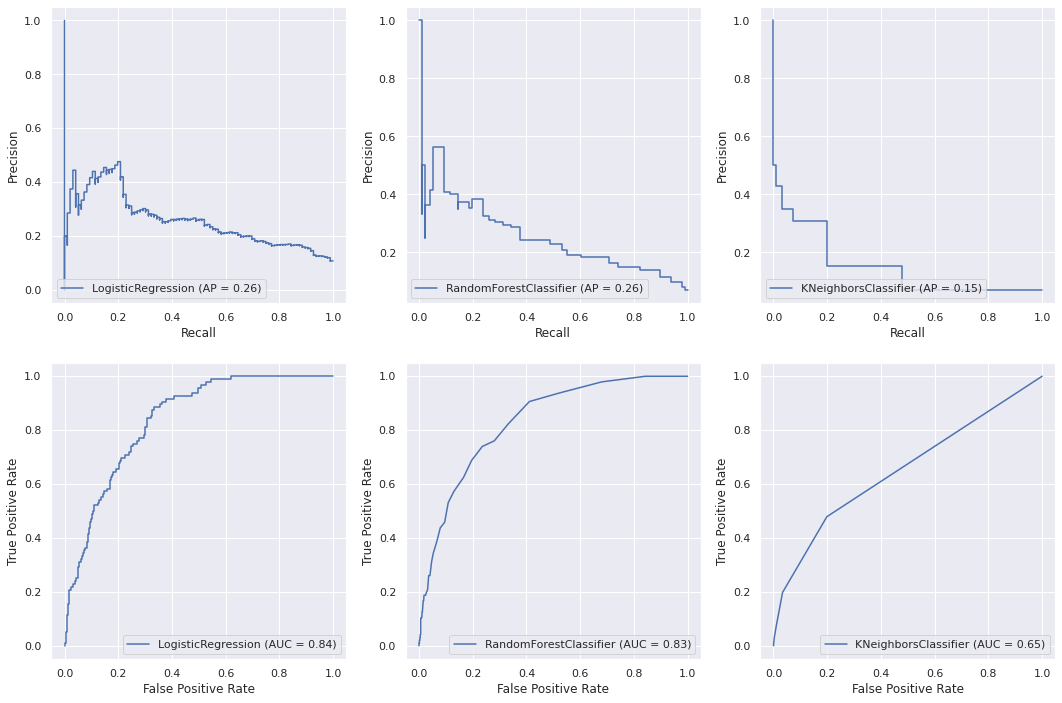

In [47]:
#class labels in variables y_train, y_test
for vec in vec_method:
  x_train, x_test, y_train, y_test = load_preprocessed(m)
  print(f"Comparison of classification methods for {vec_to_full[vec]} representation of documents")

  classifiers = [LogisticRegression(class_weight='balanced', max_iter=10000), RandomForestClassifier(class_weight='balanced'), KNeighborsClassifier()]
  fig, axs = plt.subplots(2,len(classifiers),figsize=(18,12))
  axes = [axs[0][a] for a in range(len(classifiers))]
  for i in range(len(classifiers)):
    clf = classifiers[i]
    clf.fit(x_train, y_train)
    plot_precision_recall_curve(clf,x_test, y_test, ax=axes[i])

  axes = [axs[1][a] for a in range(len(classifiers))]
  for i in range(len(classifiers)):
    clf = classifiers[i]
    clf.fit(x_train, y_train)
    plot_roc_curve(clf, x_test, y_test, ax=axes[i])
  plt.show()
  #calculate scores
  for i in range(len(classifiers)):
    class_t = class_types[i]
    clf = classifiers[i]
    y_score = clf.predict_proba(x_test)[:,1]
    auc_scores[vec][class_t]= roc_auc_score(y_test, y_score)
    avg_pr_scores[vec][class_t]=average_precision_score(y_test, y_score)
  print("\n\n")

Weighted vs. unweighted classes -  RandomForest Classifier for different data representations


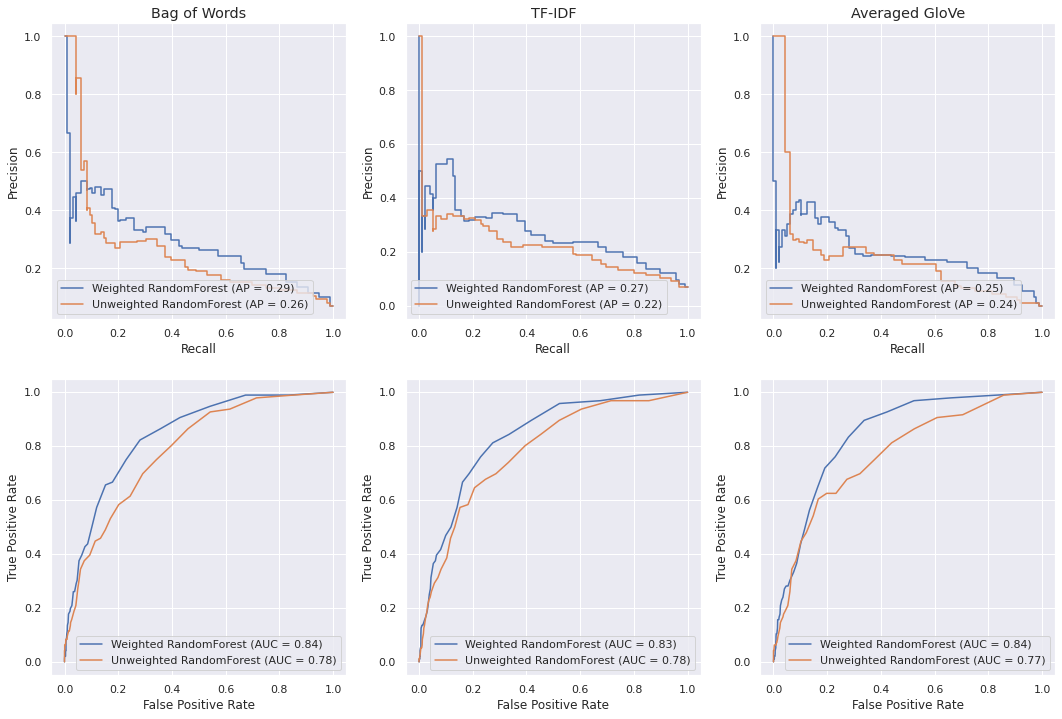

In [48]:
print("Weighted vs. unweighted classes -  RandomForest Classifier for different data representations")

results = [[], [], [], []] #[avg_u], [avg_w], [roc_u], [roc_w]

fig, axes = plt.subplots(2,len(vec_method),figsize=(18,12))

for i in range(len(vec_method)):
  rf_w = RandomForestClassifier(class_weight='balanced')
  rf_u = RandomForestClassifier()
  ax_prec = axes[0][i]
  ax_roc = axes[1][i]
  x_train, x_test, y_train, y_test = load_preprocessed(m)

  rf_w.fit(x_train, y_train)
  rf_u.fit(x_train, y_train)
  y_score_w = rf_w.predict_proba(x_test)[:,1]
  y_score_u = rf_u.predict_proba(x_test)[:,1]

  # calculate scores
  results[0].append(average_precision_score(y_test, y_score_u))
  results[1].append(average_precision_score(y_test, y_score_w))
  results[2].append(roc_auc_score(y_test, y_score_u))
  results[3].append(roc_auc_score(y_test, y_score_w))
  
  # plot curves
  plot_precision_recall_curve(rf_w, x_test, y_test, ax=ax_prec, name="Weighted RandomForest")
  plot_precision_recall_curve(rf_u, x_test, y_test, ax=ax_prec, name="Unweighted RandomForest")
  plot_roc_curve(rf_w, x_test, y_test, ax=ax_roc, name="Weighted RandomForest")
  plot_roc_curve(rf_u, x_test, y_test, ax=ax_roc, name="Unweighted RandomForest")

cols =["Bag of Words", "TF-IDF", "Averaged GloVe"]
for ax, col in zip(axes[0], cols):
  ax.annotate(col, xy=(0.5, 1), xytext=(0, 5),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')
plt.show()

Weighted vs. unweighted classes -  Logistic Regression for different data representations


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


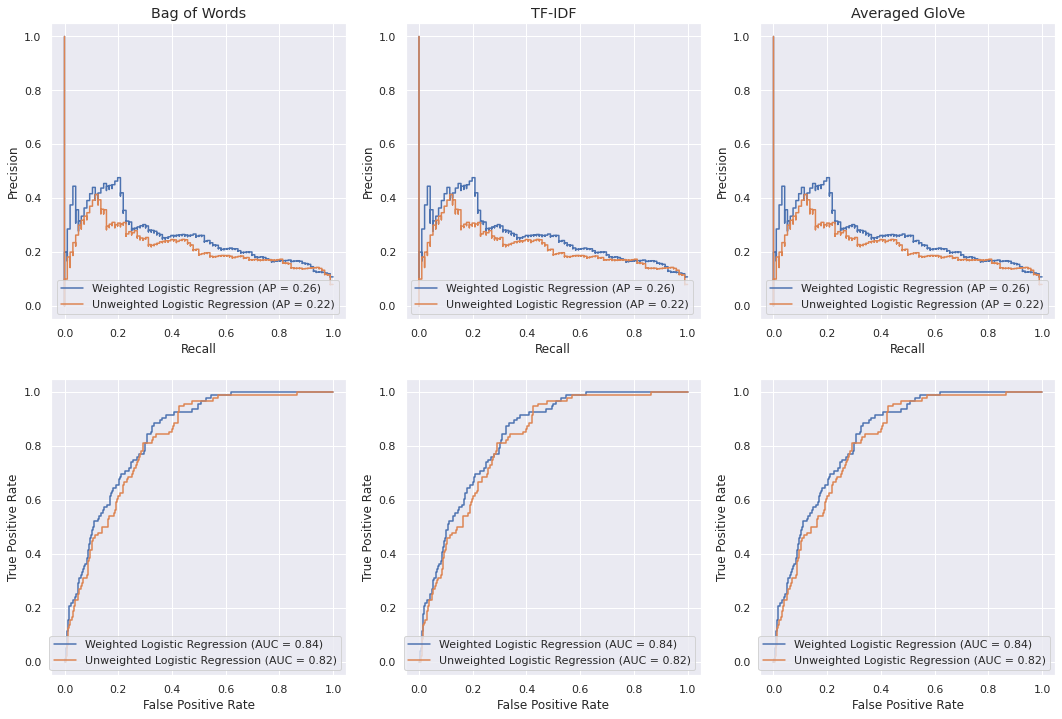

In [53]:
print("Weighted vs. unweighted classes -  Logistic Regression for different data representations")

results2 = [[], [], [], []] #[avg_u], [avg_w], [roc_u], [roc_w]

fig, axes = plt.subplots(2,len(vec_method),figsize=(18,12))

for i in range(len(vec_method)):
  rf_w = LogisticRegression(class_weight='balanced', max_iter=10000)
  rf_u = LogisticRegression()
  ax_prec = axes[0][i]
  ax_roc = axes[1][i]
  x_train, x_test, y_train, y_test = load_preprocessed(m)

  rf_w.fit(x_train, y_train)
  rf_u.fit(x_train, y_train)
  y_score_w = rf_w.predict_proba(x_test)[:,1]
  y_score_u = rf_u.predict_proba(x_test)[:,1]

  # calculate scores
  results2[0].append(average_precision_score(y_test, y_score_u))
  results2[1].append(average_precision_score(y_test, y_score_w))
  results2[2].append(roc_auc_score(y_test, y_score_u))
  results2[3].append(roc_auc_score(y_test, y_score_w))
  
  # plot curves
  plot_precision_recall_curve(rf_w, x_test, y_test, ax=ax_prec, name="Weighted Logistic Regression")
  plot_precision_recall_curve(rf_u, x_test, y_test, ax=ax_prec, name="Unweighted Logistic Regression")
  plot_roc_curve(rf_w, x_test, y_test, ax=ax_roc, name="Weighted Logistic Regression")
  plot_roc_curve(rf_u, x_test, y_test, ax=ax_roc, name="Unweighted Logistic Regression")

cols =["Bag of Words", "TF-IDF", "Averaged GloVe"]
for ax, col in zip(axes[0], cols):
  ax.annotate(col, xy=(0.5, 1), xytext=(0, 5),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')
plt.show()

In [50]:
from prettytable import PrettyTable
print("Results for unweighted classifiers and different document representations\n")
table = PrettyTable(["Classifier", "Bag of Words", "TF_IDF", "Averaged GloVe"])
table.add_row(["Logistic Regression"] +  [auc_scores[key]['log'] for key in auc_scores.keys()])
table.add_row(["Random Forest"] + [auc_scores[key]['rf'] for key in auc_scores.keys()])
table.add_row(["kNearestNeghbours"] + [auc_scores[key]['knn'] for key in auc_scores.keys()])

print(table.get_string(title="AUC ROC SCORES"), "\n")

table = PrettyTable(["Classifier", "Bag of Words", "TF_IDF", "Averaged GloVe"])
table.add_row(["Logistic Regression"] +  [auc_scores[key]['log'] for key in avg_pr_scores.keys()])
table.add_row(["Random Forest"] + [auc_scores[key]['rf'] for key in avg_pr_scores.keys()])
table.add_row(["kNearestNeghbours"] + [auc_scores[key]['knn'] for key in avg_pr_scores.keys()])
print(table.get_string(title="AVERAGE PRECISION SCORES"))

Results for unweighted classifiers and different document representations

+------------------------------------------------------------------------------------+
|                                   AUC ROC SCORES                                   |
+---------------------+--------------------+--------------------+--------------------+
|      Classifier     |    Bag of Words    |       TF_IDF       |   Averaged GloVe   |
+---------------------+--------------------+--------------------+--------------------+
| Logistic Regression | 0.8364412033411641 | 0.8364412033411641 | 0.8364412033411641 |
|    Random Forest    | 0.8232266379535369 | 0.8543502022970504 | 0.8304253132341426 |
|  kNearestNeghbours  | 0.6520164447924826 | 0.6520164447924826 | 0.6520164447924826 |
+---------------------+--------------------+--------------------+--------------------+ 

+------------------------------------------------------------------------------------+
|                              AVERAGE PRECISION SCOR

In [51]:
print("Weighted vs. unweighted classes -  RandomForest Classifier for different data representations\n")
table = PrettyTable(["Classifier ", "Bag of Words", "TF_IDF", "Averaged GloVe"])
table.add_row(["Unweighted Random Forest"] + results[2])
table.add_row(["Weighted Random Forest"] + results[3])
print(table.get_string(title="AUC ROC SCORES"), "\n")


table = PrettyTable(["Classifier", "Bag of Words", "TF_IDF", "Averaged GloVe"])
table.add_row(["Unweighted Random Forest"] + results[0])
table.add_row(["Weighted Random Forest"] + results[1])
print(table.get_string(title="AVERAGE PRECISION SCORES"), "\n")


Weighted vs. unweighted classes -  RandomForest Classifier for different data representations

+-----------------------------------------------------------------------------------------+
|                                      AUC ROC SCORES                                     |
+--------------------------+--------------------+--------------------+--------------------+
|       Classifier         |    Bag of Words    |       TF_IDF       |   Averaged GloVe   |
+--------------------------+--------------------+--------------------+--------------------+
| Unweighted Random Forest | 0.7838194988253719 | 0.7833137561994258 | 0.7675704776820673 |
|  Weighted Random Forest  | 0.8392268663534326 | 0.8339451187679459 | 0.8403729444009396 |
+--------------------------+--------------------+--------------------+--------------------+ 

+--------------------------------------------------------------------------------------------+
|                                  AVERAGE PRECISION SCORES             

In [52]:
print("Weighted vs. unweighted classes -  Logistic Regression for different data representations\n")
table = PrettyTable(["Classifier ", "Bag of Words", "TF_IDF", "Averaged GloVe"])
table.add_row(["Unweighted Logistic Regression"] + results2[2])
table.add_row(["Weighted Logistic Regression"] + results2[3])
print(table.get_string(title="AUC ROC SCORES"), "\n")


table = PrettyTable(["Classifier", "Bag of Words", "TF_IDF", "Averaged GloVe"])
table.add_row(["Unweighted Logistic Regression"] + results2[0])
table.add_row(["Weighted Logistic Regression"] + results2[1])
print(table.get_string(title="AVERAGE PRECISION SCORES"), "\n")

Weighted vs. unweighted classes -  Logistic Regression for different data representations

+-----------------------------------------------------------------------------------------------+
|                                         AUC ROC SCORES                                        |
+--------------------------------+--------------------+--------------------+--------------------+
|          Classifier            |    Bag of Words    |       TF_IDF       |   Averaged GloVe   |
+--------------------------------+--------------------+--------------------+--------------------+
| Unweighted Logistic Regression | 0.8166764552336205 | 0.8166764552336205 | 0.8166764552336205 |
|  Weighted Logistic Regression  | 0.8361883320281911 | 0.8361883320281911 | 0.8361883320281911 |
+--------------------------------+--------------------+--------------------+--------------------+ 

+--------------------------------------------------------------------------------------------------+
|                     